In [1]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import seaborn as sns 
import geopandas as gpd 
import scipy
import datetime as dt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.image as mpimg


In [5]:
#geemap.update_package()


In [6]:
ee.Initialize()

### Границы региона 

In [7]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

two_fields = geemap.geojson_to_ee('Data/archangelskoe_TWO_FIELDS_WGS84.geojson')

Budenovsk.addLayer(two_fields , {}, 'Два поля на которых работали в 2018')

Budenovsk

Map(center=[44.745544055004785, 44.14114333519604], controls=(WidgetControl(options=['position'], widget=HBox(…

### подготовка коллекции для дальнейшей обработки

In [26]:
# возьмем коллекцию сентинел и обработаем ее немного
def masking(img) : 
    cloudProb = img.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = img.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                            # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = img.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    masked_img = img.updateMask(cloud).updateMask(shadow).updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high)
    return(masked_img)




def sentinel2_NDTI(image): ##### создание NDTI 
    NDTI = image.normalizedDifference(['B11', 'B12']).rename('NDTI')
    return image.addBands([NDTI])


def sentinel2_NDVI(image): ##### создание NDVI 
    NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands([NDVI])


def NDVI_masking(img) : 
    ndvi_masked = img.select("NDVI")
    ndvi_masked = ndvi_masked.lt(0.3) ################ очень важный момент мы тут создаем маску на основании NDVI
    masked_img = img.updateMask(ndvi_masked)
    return masked_img
   
def clipper_region(image):
    clipped = image.clip(region_boundary.geometry())
    return  clipped 




In [ ]:
#создали коллекцию с изображениями
start = ee.Date('2018-09-01')
finish = ee.Date('2019-10-15') #####ВНИМАТЕЛЬНО!!!! ВОТ ЭТА ДАТА БУДЕТ МЕНЯТЬСЯ СЕЙЧАС
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(region_boundary.geometry()) \
    .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 20.0) \
    .filterMetadata('SNOW_ICE_PERCENTAGE','less_than', 5.0) \
    .filterDate(start, finish)  \
    .map(masking).map(clipper_region)
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())

#вынимаем уникальные даты из датасета
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())
sentinel2_time_list = []
for i in range(sentinel2_collection.size().getInfo()):
    img = ee.Image(sentinel2_collection_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    sentinel2_time_list.append(time)

#уникальные даты из датасета
unique_dates = sorted(list(set(sentinel2_time_list)))

diff = finish.difference(start , 'day')
Range = ee.List.sequence(0, diff.subtract(1)).map(lambda day :  start.advance(day,'day'))
def day_mosaics(date , newlist):
    date = ee.Date(date)
    newlist = ee.List(newlist)
    
    filtered = sentinel2_collection.filterDate(date , date.advance(1,'day'))
    
    image = ee.Image(filtered.mosaic())
    
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))
sentinel2_collection_mosaic = ee.ImageCollection(ee.List(Range.iterate(day_mosaics, ee.List([]))))

In [28]:
index_collection = sentinel2_collection_mosaic.map(sentinel2_NDTI).map(sentinel2_NDVI).select(['NDVI','NDTI'])
NDVI = index_collection.select('NDVI')
NDTI = index_collection.map(NDVI_masking).select('NDTI')

In [9]:
#визуал для сентинел 2 
visualization = {"min": 0.0, "max": 2000,"bands": ['B4', 'B3', 'B2']}
min: -1, max: 1, palette: ['blue', 'white', 'green']

In [62]:
#Создание датафрейма с динамикой NDTI 
collection_size = sentinel2_collection_mosaic.size().getInfo() #размер коллекции 





NDTI_list = NDTI.toList(collection_size)
NDVI_list = NDVI.toList(collection_size)


NDTI_collection = ee.Image().reproject(crs = 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040]) #это пустые коллекции 
NDVI_collection = ee.Image().reproject(crs = 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040]) #чтобы туда все загрузить

#Дата фрейм с NDTI
for i in range(collection_size): 
    img = ee.Image(NDTI_list.get(i)). \
    select("NDTI"). \
    rename(unique_dates[i]). \
    reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])
    NDTI_collection = NDTI_collection.addBands(img) #датафрейм с каналами

#датафрейм с NDVI
for k in range(collection_size): 
    img = ee.Image(NDVI_list.get(k)). \
    select("NDVI"). \
    rename(unique_dates[k]). \
    reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])
    NDVI_collection = NDVI_collection.addBands(img) #датафрейм с каналами





In [5]:
climat = pd.read_csv('Data/37061.19.02.2019.28.08.2019.1.0.0.ru.ansi.00000000.csv', sep = ';',encoding = 'ANSI', index_col = False)
climat[['date','time']] = climat['Местное время в Буденновске'].str.split(' ',1, expand=True )
climat = climat[['date', 'T', "RRR"]]

climat.RRR[climat.RRR == 'Осадков нет'] = 0 
climat.RRR[climat.RRR == 'Следы осадков'] = 0 

climat[['day','month','year']] = climat.date.str.split('.', expand=True)
climat.date = climat.year + '-' + climat.month + '-' + climat.day

climat.date = pd.to_datetime(climat.date, format='%Y-%m-%d')

climat.RRR = pd.to_numeric(climat.RRR)

climat.groupby('date')

<ipython-input-5-0a4d0a912ef9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climat.RRR[climat.RRR == 'Следы осадков'] = 0


In [14]:
rain = climat.groupby('date').sum().reset_index()[['date','RRR']]


AttributeError: 'AxesSubplot' object has no attribute 'xticks'

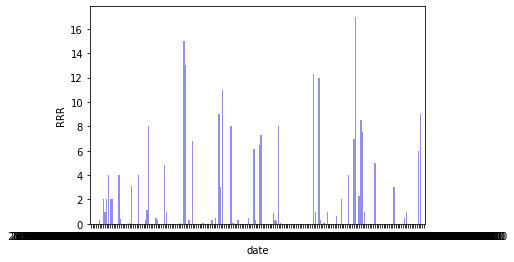

<Figure size 1440x1800 with 0 Axes>

In [27]:
fig, ax = plt.subplots()

plt.figure(figsize=(20,25))

f = sns.barplot(data = rain, x='date', y = "RRR", color = 'blue', alpha=0.5, ax =ax)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xticks(rotation='vertical')


In [63]:
Budenovsk.addLayer(NDTI_collection.select(unique_dates[0]) , {min: 0, max: 0.2, "palette": ['red', 'yellow', 'green']}, 'NDTI list')
Budenovsk.addLayer(NDVI_collection.select(unique_dates[0]) , {min: 0, max: 1, "palette": ['red', 'yellow', 'green']}, 'NDVI list')


In [32]:
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

fields = Praskoveya.append(Archangelskoe)[['type','geometry']]
fields['number'] = [i for i in range(0,fields.shape[0])]
fields_ee = geemap.geopandas_to_ee(fields)




NDTI_collection_df = NDTI_collection.reduceRegions(fields_ee, ee.Reducer.median())
geemap.ee_export_vector(NDTI_collection_df, filename = "C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/NDTI_masked_collection.csv")


NDVI_collection_df = NDVI_collection.reduceRegions(fields_ee, ee.Reducer.median())
geemap.ee_export_vector(NDVI_collection_df, filename = "C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/NDVI_Sentinel2.csv")


### Работа по кластерам


мы получили данные по группам, сейчася их добавлю и будем думать что делать дальше 

In [12]:
CLUSTER_NDVI = pd.read_csv('Data/RESULT_CLUSTER_NDVI_DATA.csv')


In [13]:
CLUSTER_NDVI.columns

Index(['Unnamed: 0', '2019-02-18', '2019-06-10', '2018-11-01', '2018-12-03',
       '2019-07-12', '2019-08-13', '2018-09-14', '2019-03-22', '2019-04-23',
       '2019-05-25', '2019-07-28', '2018-09-30', '2019-06-26', '2019-08-29',
       '2019-03-06', '2019-04-07', '2019-05-09', '2018-10-16', '2018-11-17',
       'number', 'groups', 'type', 'PC_1_45%', 'PC_2_20%', 'PC_3_16%',
       'geometry'],
      dtype='object')

In [14]:
CLUSTER_NDVI = CLUSTER_NDVI.merge(minNDTI_df , on = 'number')

NameError: name 'minNDTI_df' is not defined

In [15]:
two_fields_NDTI_df = pd.read_csv('Data/TWO_FIELDS_NDTI.csv')
PP,TT = two_fields_NDTI_df[ '2019-08-28']

In [16]:
TT

0.0115316811486536

# климатические показатели

In [17]:
climat = pd.read_csv('Data/37061.19.02.2019.28.08.2019.1.0.0.ru.ansi.00000000.csv', sep = ';',encoding = 'ANSI', index_col = False)
climat[['date','time']] = climat['Местное время в Буденновске'].str.split(' ',1, expand=True )
climat = climat[['date','T',"RRR"]]

In [18]:
climat.RRR[climat.RRR == 'Осадков нет'] = 0
climat.RRR[climat.RRR == 'Следы осадков'] = 0
climat.RRR = pd.to_numeric(climat.RRR)

<ipython-input-18-3952fa2a6ead>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climat.RRR[climat.RRR == 'Следы осадков'] = 0


In [19]:
climat

,date,T,RRR
0,28.08.2019,21.8,NaN
1,28.08.2019,27.7,0.0
2,28.08.2019,29.5,NaN
3,28.08.2019,28.4,NaN
4,28.08.2019,23.7,NaN
...,...,...,...
1523,19.02.2019,0.9,NaN
1524,19.02.2019,-2.0,NaN
1525,19.02.2019,-2.4,0.0
1526,19.02.2019,-3.9,NaN


In [203]:
climat_2019df = climat.groupby(by = 'date').sum().reset_index()[['date',"RRR"]]
climat_2019df['T'] = climat.groupby(by = 'date').mean().reset_index()[['T']]
climat_2019df['date'] = pd.to_datetime(climat_2019df['date'])
climat_2019df['date']

0     2019-02-19
1     2019-02-20
2     2019-02-21
3     2019-02-22
4     2019-02-23
         ...    
186   2019-08-24
187   2019-08-25
188   2019-08-26
189   2019-08-27
190   2019-08-28
Name: date, Length: 191, dtype: datetime64[ns]

In [21]:
climat

,date,T,RRR
0,28.08.2019,21.8,NaN
1,28.08.2019,27.7,0.0
2,28.08.2019,29.5,NaN
3,28.08.2019,28.4,NaN
4,28.08.2019,23.7,NaN
...,...,...,...
1523,19.02.2019,0.9,NaN
1524,19.02.2019,-2.0,NaN
1525,19.02.2019,-2.4,0.0
1526,19.02.2019,-3.9,NaN


### Динамика NDTI и NDVI по sentinel_2 (обработка по версии американцев)

In [22]:
NDTI_time_series = pd.read_csv('Data/NDTI_masked_collection.csv')
NDVI_time_series = pd.read_csv('Data/NDVI_Sentinel2.csv')


NDTI_time_series = NDTI_time_series.merge(CLUSTER_NDVI[['groups','number']], on = 'number').drop(["constant","system:index"], axis = 1)
NDVI_time_series = NDVI_time_series.merge(CLUSTER_NDVI[['groups','number']], on = 'number').drop(["constant","system:index"], axis = 1)


NDTI_time_series_date = NDTI_time_series.melt(id_vars = ['number', 'type','groups'], value_vars = NDTI_time_series.columns[:23], var_name = 'date')
NDVI_time_series_date = NDVI_time_series.melt(id_vars = ['number', 'type','groups'], value_vars = NDVI_time_series.columns[:23], var_name = 'date')


NDTI_time_series_date['INDEX'] = 'NDTI'
NDVI_time_series_date['INDEX'] = 'NDVI'

In [23]:
INDEX_df = NDVI_time_series_date.append(NDTI_time_series_date)

In [153]:
INDEX_df.date

0      2019-02-19
1      2019-02-19
2      2019-02-19
3      2019-02-19
4      2019-02-19
          ...    
6205   2019-08-28
6206   2019-08-28
6207   2019-08-28
6208   2019-08-28
6209   2019-08-28
Name: date, Length: 12420, dtype: datetime64[ns]

<ipython-input-198-08412f86cf7b>:59: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  ax2.locator_params(axis='x', nbins=2)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

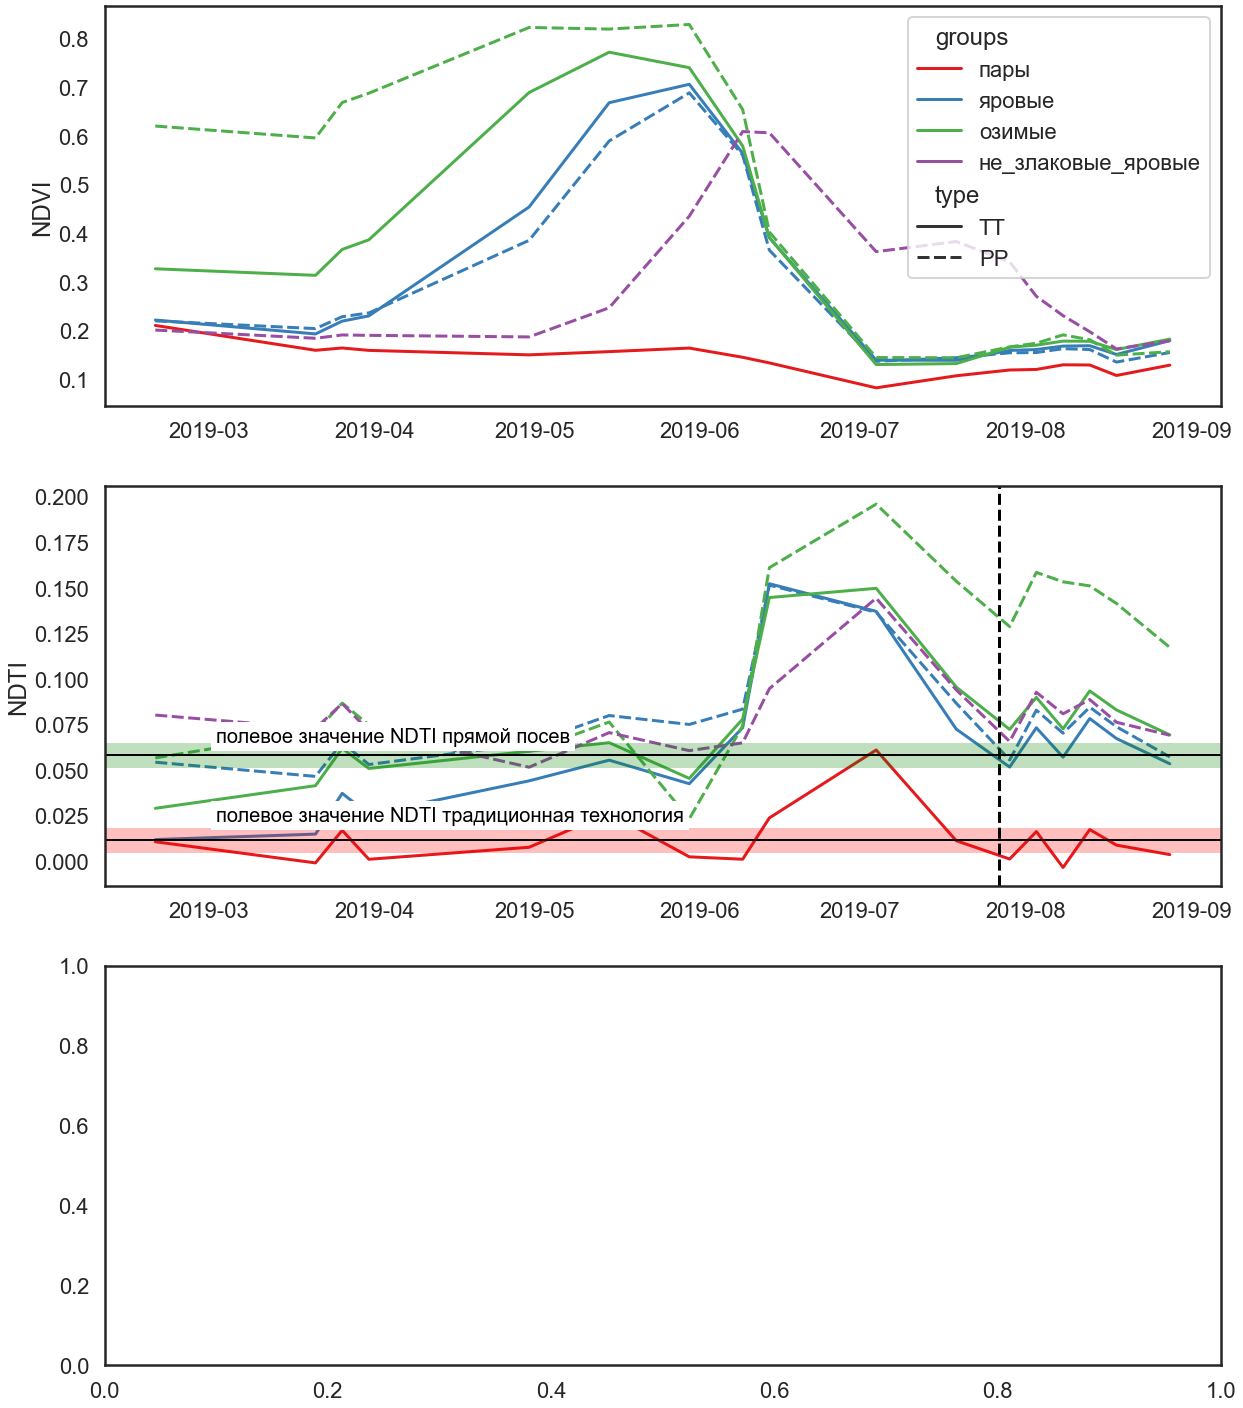

In [198]:
sns.set_style("white")
sns.set_context('poster')


fig = plt.figure(figsize=(20,25))

ax1 = plt.subplot2grid((3,1), (0, 0))
ax2 = plt.subplot2grid((3,1), (1, 0))
ax3 = plt.subplot2grid((3,1), (2, 0))

INDEX_df['date'] = pd.to_datetime(INDEX_df['date'])
INDEX_df['Index_and_type'] = INDEX_df["type"] + ' ' + INDEX_df["INDEX"]
NDVI = sns.lineplot(x="date",
             y="value",
             hue="groups",
             style ='type', 
             data = INDEX_df[INDEX_df['INDEX'] == 'NDVI'],
             palette='Set1',
            err_style="bars",
             ci=None,
             ax = ax1
)
ax1.set_xlabel("")
ax1.set_ylabel("NDVI")





NDTI = sns.lineplot(x="date",
             y="value",
             hue="groups",
             style ='type', 
             data = INDEX_df[INDEX_df['INDEX'] == 'NDTI'],
             palette='Set1',
            err_style="bars",
             ci=None,
             ax = ax2
)

ax2.axhline(y = TT,color ='red', linewidth=25, alpha = 0.25)
ax2.axhline(y = TT,color ='black', linewidth=2)
ax2.axvline(18104, linestyle ='--', color = 'black' )
ax2.text(0.1, TT+ 0.15, 
         'полевое значение NDTI традиционная технология',
         transform=ax2.transAxes, 
         fontsize=20, 
         color = 'black',backgroundcolor = 'white')
ax2.text(0.1, PP+0.30, 
         'полевое значение NDTI прямой посев',
         transform=ax2.transAxes, 
         fontsize=20, 
         color = 'black', backgroundcolor = 'white')
ax2.axhline(y = PP,color ='green', linewidth=25, alpha = 0.25)
ax2.axhline(y = PP,color ='black', linewidth=2)
ax2.set_xlabel("")
ax2.set_ylabel("NDTI")
ax2.get_legend().set_visible(False)
ax2.locator_params(axis='x', nbins=2)

tick = NDVI.get_xticks()

plt.xticks()

#  нужно дооформить все красиво и перехатьдить к классификации

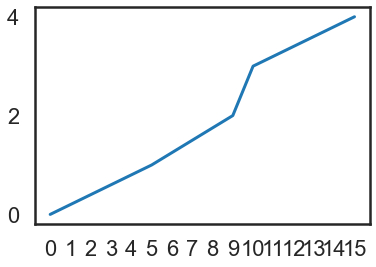

In [33]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [34]:
np.arange(min(x), max(x)+1, 1.0)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])